# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO2: Breast Tumor Segmentation with Attention Mechanisms and Genetic Algorithm Optimization

This notebook implements the breast tumor segmentation model described in the research paper "Explainable attention based breast tumor segmentation using a combination of UNet, ResNet, DenseNet, and EfficientNet models". We extend the original approach by adding genetic algorithm-based hyperparameter optimization and optimizing for Apple Silicon (MPS).

### 1. Setup and Environment Preparation

In [1]:
# Import required libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import random
import pygad
import warnings
import gc

from dataset import BUSIDataset

# Check for GPU availability
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

# Disable warnings
warnings.filterwarnings('ignore')

print("Setup complete!")

tensor([1.], device='mps:0')
Setup complete!


### 2. Loading and Configuration of the BUSI Dataset

This cell handles the setup for loading and organizing the BUSI dataset. We focus on loading benign and malignant breast tumor ultrasound images and their corresponding masks, similar to the approach in the paper.

Dataset found. Loading data...
Success: 647 image-mask pairs loaded.
Train set: 517 images
Validation set: 65 images
Test set: 65 images


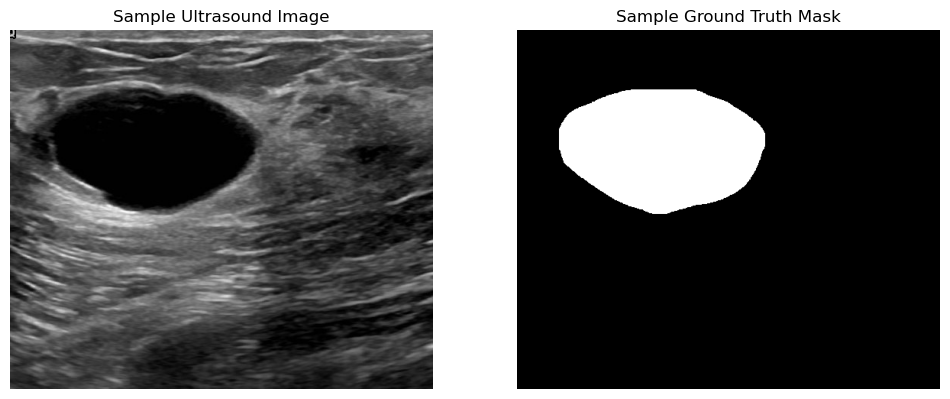

In [3]:
# Configuration settings
IMAGE_SIZE = (224, 224)  # Image size used in the paper
BATCH_SIZE = 16  # Will be optimized with genetic algorithm later

# Function to load and preprocess dataset
def load_dataset(dataset_path):
    """
    Load BUSI dataset images and masks, focusing only on benign and malignant categories
    as mentioned in the paper.
    
    Args:
        dataset_path: Path to the BUSI dataset
        
    Returns:
        Lists of image paths and corresponding mask paths
    """
    image_paths = []
    mask_paths = []
    
    for category in ['benign', 'malignant']:  # Only benign and malignant!
        category_path = os.path.join(dataset_path, category)
        
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist!")
            continue
        
        files = os.listdir(category_path)
        files_set = set(files)
        
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')) and '_mask' not in file:
                mask_file = file.split('.')[0] + '_mask.' + file.split('.')[-1]
                if mask_file in files_set:
                    image_paths.append(os.path.join(category_path, file))
                    mask_paths.append(os.path.join(category_path, mask_file))
                else:
                    print(f"Warning: Mask missing for image {file} in {category}")
    
    # Check final lengths
    if len(image_paths) != len(mask_paths):
        print(f"Error: {len(image_paths)} images and {len(mask_paths)} masks loaded (should be equal).")
    else:
        print(f"Success: {len(image_paths)} image-mask pairs loaded.")
    
    return image_paths, mask_paths

# Data paths
dataset_path = '/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/Dataset_BUSI_with_GT2'  # Update this to your dataset path

# Check if dataset exists
if not os.path.exists(dataset_path):
    print("Dataset not found. Please download and extract it to the specified path.")
    print("Dataset can be downloaded from: https://www.kaggle.com/datasets/sabahesaraki/breast-ultrasound-images-dataset")
else:
    print("Dataset found. Loading data...")
    # Load dataset
    image_paths, mask_paths = load_dataset(dataset_path)
    
    # Split data into train, validation, and test sets (80%, 10%, 10%)
    train_img_paths, temp_img_paths, train_mask_paths, temp_mask_paths = train_test_split(
        image_paths, mask_paths, test_size=0.2, random_state=seed
    )
    val_img_paths, test_img_paths, val_mask_paths, test_mask_paths = train_test_split(
        temp_img_paths, temp_mask_paths, test_size=0.5, random_state=seed
    )
    
    print(f"Train set: {len(train_img_paths)} images")
    print(f"Validation set: {len(val_img_paths)} images")
    print(f"Test set: {len(test_img_paths)} images")
    
    # Visualize sample image and mask
    if len(image_paths) > 0:
        sample_idx = np.random.randint(0, len(train_img_paths))
        sample_img = cv2.imread(train_img_paths[sample_idx])
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        sample_mask = cv2.imread(train_mask_paths[sample_idx], cv2.IMREAD_GRAYSCALE)
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_img)
        plt.title('Sample Ultrasound Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(sample_mask, cmap='gray')
        plt.title('Sample Ground Truth Mask')
        plt.axis('off')
        plt.show()

In [4]:
# Create PyTorch Dataset and DataLoaders
# Import the BUSIDataset
from dataset import BUSIDataset

# Create Dataset objects
train_dataset = BUSIDataset(train_img_paths, train_mask_paths, image_size=(224, 224), augment=True)
val_dataset = BUSIDataset(val_img_paths, val_mask_paths, image_size=(224, 224), augment=False)
test_dataset = BUSIDataset(test_img_paths, test_mask_paths, image_size=(224, 224), augment=False)

# Create DataLoaders
BATCH_SIZE = 16 # Same as your config
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
print(f"DataLoaders ready: {len(train_loader)} training batches, {len(val_loader)} validation batches, {len(test_loader)} test batches.")

DataLoaders ready: 33 training batches, 5 validation batches, 5 test batches.


### 3. Data Preprocessing and Augmentation

This cell implements data preprocessing and augmentation techniques to enhance model performance. The preprocessing steps ensure images and masks are properly normalized and prepared for training.

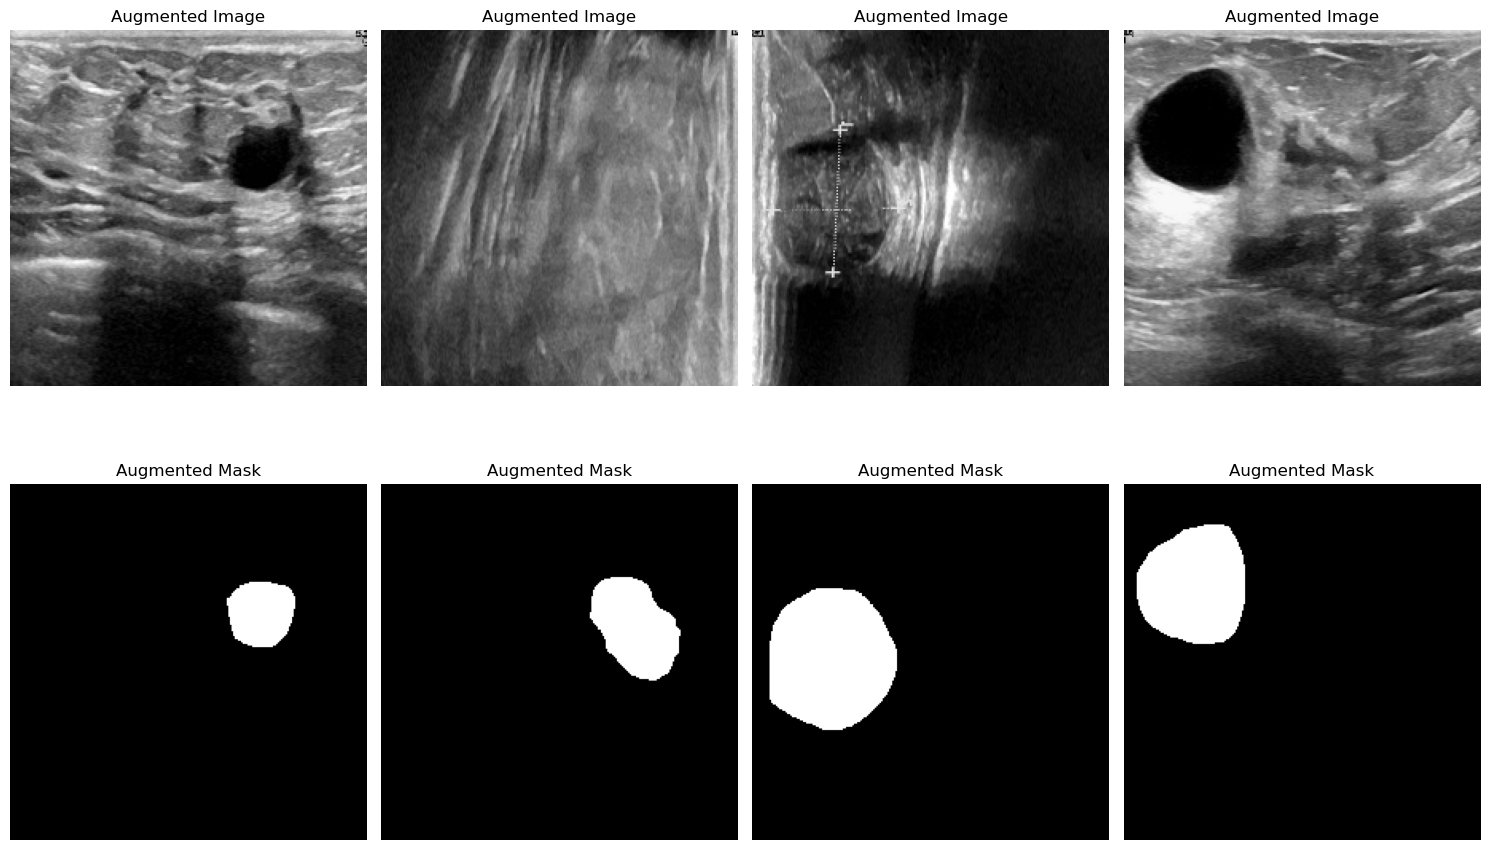

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

# Data preprocessing and augmentation functions
def preprocess_image(image_path, mask_path, image_size=IMAGE_SIZE):
    """
    Preprocess image and mask for model input.
    
    Args:
        image_path: Path to the image file
        mask_path: Path to the mask file
        image_size: Target size for resizing
        
    Returns:
        Preprocessed image and mask
    """
    # Load image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image and mask
    image = cv2.resize(image, image_size)
    mask = cv2.resize(mask, image_size)
    
    # Normalize image to [0, 1]
    image = image / 255.0
    
    # Ensure mask is binary
    mask = (mask > 128).astype(np.float32)
    
    return image, mask

# Data generator for training
class DataGenerator(Dataset):
    """
    Data generator for feeding batches to the model during training.
    Implements data augmentation techniques.
    """
    def __init__(self, image_paths, mask_paths, image_size=IMAGE_SIZE, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.augment = augment
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and preprocess image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image, mask = preprocess_image(img_path, mask_path, self.image_size)
        
        # Apply augmentation if enabled
        if self.augment:
            if np.random.rand() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()
            if np.random.rand() > 0.5:
                image = np.flipud(image).copy()
                mask = np.flipud(mask).copy()
            if np.random.rand() > 0.5:
                k = np.random.randint(0, 4)
                image = np.rot90(image, k).copy()
                mask = np.rot90(mask, k).copy()
            if np.random.rand() > 0.5:
                brightness_factor = np.random.uniform(0.8, 1.2)
                image = np.clip(image * brightness_factor, 0, 1).copy()
            
        # Convert to tensor
        image = torch.from_numpy(image.transpose((2, 0, 1))).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        return image, mask

# Create data loaders
if 'train_img_paths' in locals():
    # Create datasets
    train_dataset = DataGenerator(
        train_img_paths, train_mask_paths, 
        image_size=IMAGE_SIZE, 
        augment=True
    )
    
    val_dataset = DataGenerator(
        val_img_paths, val_mask_paths, 
        image_size=IMAGE_SIZE, 
        augment=False
    )
    
    test_dataset = DataGenerator(
        test_img_paths, test_mask_paths, 
        image_size=IMAGE_SIZE, 
        augment=False
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Show a batch of augmented images
    X_batch, y_batch = next(iter(train_loader))
    
    plt.figure(figsize=(15, 10))
    for i in range(min(4, X_batch.shape[0])):
        plt.subplot(2, 4, i+1)
        img = X_batch[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title('Augmented Image')
        plt.axis('off')
        
        plt.subplot(2, 4, i+5)
        mask = y_batch[i, 0, :, :].numpy()
        plt.imshow(mask, cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### 4. Model Components - Attention Mechanisms

This cell implements the core attention mechanisms described in the paper: Convolutional Block Attention Module (CBAM) and Non-Local Attention. These components help the model focus on the most relevant features in breast ultrasound images, improving segmentation accuracy.

In [6]:
# Implementing Convolutional Block Attention Module (CBAM)
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention Module
class ChannelAttention(nn.Module):
    """
    Channel Attention Module as described in the paper.
    This focuses on 'what' is important by emphasizing important feature channels.
    """
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        # Average and Max pooling layers
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Shared MLP
        self.shared_MLP = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=True),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=True)
        )
        
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        b, c, _, _ = x.size()
        
        # Average pooling branch
        avg_out = self.avg_pool(x).view(b, c)
        avg_out = self.shared_MLP(avg_out)
        
        # Max pooling branch
        max_out = self.max_pool(x).view(b, c)
        max_out = self.shared_MLP(max_out)
        
        # Combine branches and apply sigmoid
        out = avg_out + max_out
        out = self.sigmoid(out).view(b, c, 1, 1)
        
        # Scale input feature maps
        return x * out

# Spatial Attention Module
class SpatialAttention(nn.Module):
    """
    Spatial Attention Module as described in the paper.
    This focuses on 'where' is important by emphasizing important spatial locations.
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        # Kernel padding
        padding = kernel_size // 2
        
        # Convolutional layer
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        
        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Average and max pooling along channel axis
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate along channel axis
        x_cat = torch.cat([avg_out, max_out], dim=1)
        
        # Apply convolution and sigmoid
        x_out = self.conv1(x_cat)
        return x * self.sigmoid(x_out)

# CBAM Block (Channel + Spatial Attention)
class CBAM(nn.Module):
    """
    Complete CBAM block combining channel and spatial attention.
    """
    def __init__(self, in_planes, ratio=8, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_planes, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # Apply channel attention
        out = self.channel_attention(x)
        # Apply spatial attention
        out = self.spatial_attention(out)
        return out

# Non-Local Block
class NonLocalBlock(nn.Module):
    """
    Non-Local Attention mechanism that captures long-range dependencies
    as described in the paper.
    """
    def __init__(self, in_channels, compression=2):
        super(NonLocalBlock, self).__init__()
        
        # Increase compression to reduce intermediate dimensions
        inter_channels = in_channels // compression
        if inter_channels == 0:
            inter_channels = 1
        
        # g path (query)
        self.g = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # theta path (key)
        self.theta = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # phi path (value)
        self.phi = nn.Conv2d(in_channels, inter_channels, kernel_size=1)
        # Final convolution to project back
        self.concat_project = nn.Conv2d(inter_channels, in_channels, kernel_size=1)
        # Batch normalization
        self.bn = nn.BatchNorm2d(in_channels)
        # Add spatial reduction to lower memory footprint
        self.spatial_reduction = 2

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Spatial reduction for memory efficiency
        H_reduced, W_reduced = H // self.spatial_reduction, W // self.spatial_reduction
        # Downsample input for attention computation
        x_reduced = F.interpolate(x, size=(H_reduced, W_reduced), mode='bilinear', align_corners=False)
        # Apply g, reshape and transpose
        g_x = self.g(x_reduced).view(batch_size, -1, H_reduced * W_reduced).permute(0, 2, 1)
        # Apply theta, reshape and transpose
        theta_x = self.theta(x_reduced).view(batch_size, -1, H_reduced * W_reduced).permute(0, 2, 1)
        # Apply phi and reshape
        phi_x = self.phi(x_reduced).view(batch_size, -1, H_reduced * W_reduced)
        # Similarity matrix in chunks to reduce memory usage
        # Process in smaller chunks of 512x512 or less
        chunk_size = min(512, H_reduced * W_reduced)
        num_chunks = (H_reduced * W_reduced + chunk_size - 1) // chunk_size
        
        # Initialize empty tensor for results
        f_div_C = torch.zeros(batch_size, H_reduced * W_reduced, H_reduced * W_reduced,
                              device=x.device, dtype=x.dtype)
        
        for i in range(num_chunks):
            row_start = i * chunk_size
            row_end = min((i + 1) * chunk_size, H_reduced * W_reduced)
            for j in range(num_chunks):
                col_start = j * chunk_size
                col_end = min((j + 1) * chunk_size, H_reduced * W_reduced)
                # Compute similarity for this chunk
                theta_chunk = theta_x[:, row_start:row_end, :]
                phi_chunk = phi_x[:, :, col_start:col_end]
                f_chunk = torch.matmul(theta_chunk, phi_chunk)
                # Apply softmax by row
                f_div_C_chunk = F.softmax(f_chunk, dim=-1)
                # Store result
                f_div_C[:, row_start:row_end, col_start:col_end] = f_div_C_chunk
        
        # Attention output
        y = torch.matmul(f_div_C, g_x)
        # Clean up to free memory
        del f_div_C, g_x, theta_x, phi_x
        torch.cuda.empty_cache() if torch.cuda.is_available() else gc.collect()
        # Reshape and permute
        y = y.permute(0, 2, 1).contiguous().view(batch_size, -1, H_reduced, W_reduced)
        # Upsample back to original resolution
        y = F.interpolate(y, size=(H, W), mode='bilinear', align_corners=False)
        # Project and add residual connection
        y = self.concat_project(y)
        y = self.bn(y)
        return x + y

# Depthwise Separable Convolution Block
class DepthwiseSeparableConvBlock(nn.Module):
    """
    Depthwise Separable Convolution block with ReLU6 activation
    to reduce computational complexity.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(DepthwiseSeparableConvBlock, self).__init__()
        
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   stride=stride, padding=kernel_size//2, groups=in_channels, bias=False)
        
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu6(self.bn1(self.depthwise(x)))
        x = F.relu6(self.bn2(self.pointwise(x)))
        return x

# Test the modules with a small tensor to verify
def test_attention_modules():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    sample_tensor = torch.randn(2, 64, 28, 28).to(device)
    
    cbam = CBAM(64).to(device)
    non_local = NonLocalBlock(64).to(device)
    dsc = DepthwiseSeparableConvBlock(64, 64).to(device)
    
    with torch.no_grad():
        cbam_output = cbam(sample_tensor)
        dsc_output = dsc(sample_tensor)
        # Process non-local in smaller batches to save memory
        non_local_output = non_local(sample_tensor[:1])
        if sample_tensor.shape[0] > 1:
            non_local_output2 = non_local(sample_tensor[1:])
            non_local_output = torch.cat([non_local_output, non_local_output2], dim=0)
    
    print(f"CBAM output shape: {cbam_output.shape}")
    print(f"DSC output shape: {dsc_output.shape}")
    print(f"Non-Local output shape: {non_local_output.shape}")
    print("All modules tested successfully!")

test_attention_modules()

CBAM output shape: torch.Size([2, 64, 28, 28])
DSC output shape: torch.Size([2, 64, 28, 28])
Non-Local output shape: torch.Size([2, 64, 28, 28])
All modules tested successfully!


### 5. Model Definition - Multi-Encoder UNet Architecture

This cell implements the complete model architecture based on the paper. It combines the UNet base with multiple encoder backbones (ResNet-18, DenseNet-121, EfficientNet-B0) and the attention mechanisms we defined earlier.

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    """
    Encoder block that uses pretrained models from torchvision
    """
    def __init__(self, pretrained=True):
        super(EncoderBlock, self).__init__()
        
        # Load models with strict=False to allow partial loading and reduce overhead
        self.resnet = models.resnet18(pretrained=pretrained)
        self.densenet = models.densenet121(pretrained=pretrained)
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        
        # Get feature dimensions
        self.resnet_features = 512        # Final feature size of ResNet18
        self.densenet_features = 1024      # Final feature size of DenseNet121
        self.efficientnet_features = 1280  # Final feature size of EfficientNet-B0
        
        # Calculate total feature dimension
        self.out_features = self.resnet_features + self.densenet_features + self.efficientnet_features
        
        # Common output spatial size
        self.output_size = (7, 7)
        
        # Precompute settings to speed up forward pass
        self.has_initialized_forward = False
        
    def _initialize_forward(self, x):
        """
        Precompute sizes and settings to make forward pass more efficient.
        """
        # Store input size for later reference
        self.input_size = (x.size(2), x.size(3))
        
        # Run once to determine skip connection sizes
        with torch.no_grad():
            # ResNet
            resnet_features = self.resnet.conv1(x)
            resnet_features = self.resnet.bn1(resnet_features)
            resnet_features = self.resnet.relu(resnet_features)
            resnet_features = self.resnet.maxpool(resnet_features)
            
            resnet_features = self.resnet.layer1(resnet_features)
            skip1_size = (resnet_features.size(2), resnet_features.size(3))
            
            resnet_features = self.resnet.layer2(resnet_features)
            skip2_size = (resnet_features.size(2), resnet_features.size(3))
            
            resnet_features = self.resnet.layer3(resnet_features)
            skip3_size = (resnet_features.size(2), resnet_features.size(3))
            
            # Save dimensions for future reference
            self.skip1_size = skip1_size
            self.skip2_size = skip2_size
            self.skip3_size = skip3_size
        
        self.has_initialized_forward = True
        
    def forward(self, x):
        # Initialize forward settings on the first pass
        if not self.has_initialized_forward:
            self._initialize_forward(x)
        
        # Store input size
        input_size = (x.size(2), x.size(3))
        
        # Process through ResNet (removing the final classification layer)
        resnet_features = self.resnet.conv1(x)
        resnet_features = self.resnet.bn1(resnet_features)
        resnet_features = self.resnet.relu(resnet_features)
        resnet_features = self.resnet.maxpool(resnet_features)
        
        resnet_features = self.resnet.layer1(resnet_features)
        resnet_skip1 = resnet_features  # Skip connection 1 (56x56)
        
        resnet_features = self.resnet.layer2(resnet_features)
        resnet_skip2 = resnet_features  # Skip connection 2 (28x28)
        
        resnet_features = self.resnet.layer3(resnet_features)
        resnet_skip3 = resnet_features  # Skip connection 3 (14x14)
        
        resnet_features = self.resnet.layer4(resnet_features)  # 7x7
        
        # Process with DenseNet (only features)
        densenet_features = self.densenet.features(x)
        
        # Process with EfficientNet (only features)
        efficientnet_features = self.efficientnet.features(x)
        
        # Resize all feature maps to the same spatial size (7x7)
        # Use precomputed output_size for faster resizing
        if resnet_features.size(2) != self.output_size[0] or resnet_features.size(3) != self.output_size[1]:
            resnet_features = F.adaptive_avg_pool2d(resnet_features, self.output_size)

        if densenet_features.size(2) != self.output_size[0] or densenet_features.size(3) != self.output_size[1]:
            densenet_features = F.adaptive_avg_pool2d(densenet_features, self.output_size)
        
        if efficientnet_features.size(2) != self.output_size[0] or efficientnet_features.size(3) != self.output_size[1]:
            efficientnet_features = F.adaptive_avg_pool2d(efficientnet_features, self.output_size)
        
        # Concatenate features
        combined_features = torch.cat([resnet_features, densenet_features, efficientnet_features], dim=1)
        
        return combined_features, [resnet_skip1, resnet_skip2, resnet_skip3], input_size

class DecoderBlock(nn.Module):
    """
    Decoder block for the UNet architecture
    """
    def __init__(self, in_channels, out_channels, use_dsc=True, use_cbam=True, use_non_local=True):
        super(DecoderBlock, self).__init__()
        self.use_dsc = use_dsc
        self.use_cbam = use_cbam
        self.use_non_local = use_non_local
        
        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Convolution blocks
        if use_dsc:
            self.conv1 = DepthwiseSeparableConvBlock(in_channels, out_channels)
            self.conv2 = DepthwiseSeparableConvBlock(out_channels, out_channels)
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU6(inplace=True)
            )
        
        # Attention modules
        if use_cbam:
            self.cbam = CBAM(out_channels)
        
        if use_non_local:
            self.non_local = NonLocalBlock(out_channels)
            
    def forward(self, x, skip=None):
        x = self.upsample(x)
        
        # Concatenate with skip connection if provided
        if skip is not None:
            # Ensure the dimensions match
            if x.size(2) != skip.size(2) or x.size(3) != skip.size(3):
                x = F.interpolate(
                    x, size=(skip.size(2), skip.size(3)), mode='bilinear', align_corners=False
                )
            # Concatenate along channel dimension
            x = torch.cat([x, skip], dim=1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Apply attention
        if self.use_cbam:
            x = self.cbam(x)
        
        if self.use_non_local:
            # Process in smaller chunks to save memory
            batch_size = x.size(0)
            if batch_size > 1:
                # Process in chunks of 1
                outputs = []
                for i in range(batch_size):
                    outputs.append(self.non_local(x[i:i+1]))
                x = torch.cat(outputs, dim=0)
            else:
                x = self.non_local(x)
        
        return x

class MultiEncoderUNet(nn.Module):
    """
    UNet-based model with multiple encoders as proposed in the paper
    """
    def __init__(self, n_classes=1, use_dsc=True, use_cbam=True, use_non_local=True, pretrained=True):
        super(MultiEncoderUNet, self).__init__()
        self.n_classes = n_classes
        
        # Encoder
        self.encoder = EncoderBlock(pretrained=pretrained)
        
        # Get the output features from encoder
        encoder_features = self.encoder.out_features
        
        # Decoder path
        self.decoder4 = DecoderBlock(encoder_features, 512, use_dsc, use_cbam, use_non_local)
        self.decoder3 = DecoderBlock(512 + 256, 256, use_dsc, use_cbam, use_non_local)  # 256 from skip connection
        self.decoder2 = DecoderBlock(256 + 128, 128, use_dsc, use_cbam, use_non_local)  # 128 from skip connection
        self.decoder1 = DecoderBlock(128 + 64, 64, use_dsc, use_cbam, use_non_local)    # 64 from skip connection
        
        # Final upsampling to original input size and convolution
        self.final_upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  # 56x56 -> 224x224
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        features, skip_connections, input_size = self.encoder(x)
        
        # Decoder with skip connections
        x = self.decoder4(features)
        x = self.decoder3(x, skip_connections[2])  # Using ResNet skip3
        x = self.decoder2(x, skip_connections[1])  # Using ResNet skip2
        x = self.decoder1(x, skip_connections[0])  # Using ResNet skip1
        
        # Final upsampling to match original input size
        # After decoder1, x should be 56x56, we need to upsample to 224x224
        x = self.final_upsample(x)
        
        # Ensure output size matches input size exactly
        if x.size(2) != input_size[0] or x.size(3) != input_size[1]:
            x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        # Final convolution
        x = self.final_conv(x)
        
        # Apply sigmoid for binary segmentation
        x = torch.sigmoid(x)
        
        return x

# Test the model with a sample input to verify dimensions
def test_model():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create a small input tensor
    x = torch.randn(1, 3, 224, 224).to(device)
    
    # Create model
    model = MultiEncoderUNet(
        n_classes=1,
        use_dsc=True,
        use_cbam=True,
        use_non_local=True,  # Set to False to save memory
        pretrained=False  # Set to False for faster testing
    ).to(device)
    
    # Switch to evaluation mode
    model.eval()
    
    print("Model created, running forward pass...")
    
    # Forward pass
    with torch.no_grad():
        output = model(x)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print("Model test successful!")
    
    return model

# Run model test
fixed_model = test_model()

Using device: mps
Model created, running forward pass...
Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])
Model test successful!


### 6. Loss Functions and Evaluation Metrics

This cell implements the loss functions and evaluation metrics used for training and evaluating the breast tumor segmentation model. These include Dice Loss, Binary Cross-Entropy Loss, and metrics such as Dice coefficient and IoU.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dice Loss
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation
    """
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection
        intersection = (predictions * targets).sum()
        
        # Calculate Dice coefficient
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss
        return 1 - dice

# Combined BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    """
    Combined Binary Cross-Entropy and Dice Loss
    """
    def __init__(self, weight_bce=0.5, weight_dice=0.5, smooth=1.0):
        super(BCEDiceLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()
        self.dice = DiceLoss(smooth=smooth)
        
    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)
        combined_loss = self.weight_bce * bce_loss + self.weight_dice * dice_loss
        return combined_loss

# Evaluation metrics
def dice_coefficient(predictions, targets, smooth=1.0):
    """
    Calculate Dice coefficient
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection
    intersection = (predictions * targets).sum()
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()

def iou_score(predictions, targets, smooth=1.0):
    """
    Calculate IoU (Intersection over Union) score
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection and union
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()

def precision_recall_f1(predictions, targets):
    """
    Calculate precision, recall, and F1 score
    """
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate true positives, false positives, false negatives
    tp = (predictions * targets).sum().item()
    fp = (predictions * (1 - targets)).sum().item()
    fn = ((1 - predictions) * targets).sum().item()
    
    # Calculate metrics
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    return precision, recall, f1

# Test the loss functions and metrics
def test_loss_functions():
    # Create sample predictions and targets
    predictions = torch.rand(2, 1, 224, 224)
    targets = torch.randint(0, 2, (2, 1, 224, 224)).float()
    
    # Calculate losses
    dice_loss = DiceLoss()(predictions, targets)
    bce_loss = nn.BCELoss()(predictions, targets)
    combined_loss = BCEDiceLoss()(predictions, targets)
    
    # Calculate metrics
    dice = dice_coefficient(predictions, targets)
    iou = iou_score(predictions, targets)
    precision, recall, f1 = precision_recall_f1(predictions, targets)
    
    print(f"Dice Loss: {dice_loss.item():.4f}")
    print(f"BCE Loss: {bce_loss.item():.4f}")
    print(f"Combined Loss: {combined_loss.item():.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"IoU Score: {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Run test
test_loss_functions()

Dice Loss: 0.5006
BCE Loss: 1.0030
Combined Loss: 0.7518
Dice Coefficient: 0.5007
IoU Score: 0.3340
Precision: 0.4994
Recall: 0.5020
F1 Score: 0.5007


In [9]:
# Optimized function to train the model with specific hyperparameter settings
def train_model_optimized(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=4):
    """
    Optimized training function to reduce time and memory usage
    """
    best_val_dice = 0
    patience_counter = 0
    train_losses = []
    val_dices = []
    
    # Check if we can use mixed precision
    use_amp = hasattr(torch.cuda, 'amp') and device.type == 'cuda'
    if use_amp:
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler()
        print("Using mixed precision training")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        train_loss = 0
        batch_count = 0
        
        # Use a progress bar to monitor
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for inputs, targets in progress_bar:
            # Move data to the device with non_blocking to parallelize transfer
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            # Memory optimization - set_to_none is more efficient than zero_grad()
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass with mixed precision if available
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Free GPU memory after every 5 batches to reduce fragmentation
            if batch_count % 5 == 0:
                del outputs
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Compute average training loss
        avg_train_loss = train_loss / batch_count
        train_losses.append(avg_train_loss)
        
        # === VALIDATION PHASE ===
        model.eval()
        val_dice_sum = 0
        val_batch_count = 0
        
        # No gradients accumulation in validation to save memory
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                
                # Batch splitting to reduce GPU memory footprint
                if inputs.size(0) > 8 and device.type in ['cuda', 'mps']:
                    sub_batch_size = 8
                    sub_outputs = []
                    
                    for i in range(0, inputs.size(0), sub_batch_size):
                        end_idx = min(i + sub_batch_size, inputs.size(0))
                        sub_input = inputs[i:end_idx]
                        sub_output = model(sub_input)
                        sub_outputs.append(sub_output)
                    
                    outputs = torch.cat(sub_outputs, dim=0)
                else:
                    outputs = model(inputs)
                
                # Calculate Dice
                dice = dice_coefficient(outputs, targets)
                val_dice_sum += dice
                val_batch_count += 1
                
                # Free memory
                del outputs
        
        # Compute average validation Dice
        avg_val_dice = val_dice_sum / val_batch_count
        val_dices.append(avg_val_dice)
        
        # Update the scheduler
        scheduler.step(1 - avg_val_dice)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={avg_train_loss:.4f}, Validation Dice={avg_val_dice:.4f}")
        
        # Save the best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            # Save only model weights to save space
            torch.save(model.state_dict(), f'best_model_epoch_{epoch+1}.pt')
            print(f"Model saved with validation Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        # Aggressively clean memory after each epoch
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Final information
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds")
    print(f"Best validation Dice: {best_val_dice:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_dices': val_dices,
        'best_val_dice': best_val_dice,
        'training_time': total_time
    }

### 7. Hyperparameter Optimization with Genetic Algorithm

This cell implements genetic algorithm-based hyperparameter optimization to find the best model configuration. The genetic algorithm searches through different combinations of hyperparameters like learning rate, batch size, and model architecture options to maximize segmentation performance. This approach is more powerful than manual tuning and can discover optimal configurations that humans might miss.

In [9]:
class IntensiveHyperparameterOptimizer:
    """
    Hyperparameter optimizer designed for deep and exhaustive search,
    with minimal output and robust error handling.
    Focuses only on training hyperparameters, preserving the model architecture from the paper.
    """
    def __init__(self, train_dataset, val_dataset):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Search space definition - only training hyperparameters, not architecture
        self.learning_rates = [1e-5, 5e-5, 1e-4, 5e-4]
        self.batch_sizes = [8, 16, 24]
        self.weight_decay_options = [ 1e-6, 1e-5]
        self.loss_functions = ['bce', 'dice', 'combined']
        self.optimizer_types = ['adamw'] # Fixed to 'adamw' for simplicity
        self.scheduler_patience_options = [3] # Fixed to 4 for simplicity

        # Internal trackers
        self.fitness_cache = {}
        self.generation_history = []
        self.best_fitness_history = []
        self.all_evaluations = []
        self.best_overall_fitness = 0
        self.best_overall_solution = None
        self.best_model_path = None
        self.start_time = time.time()
        self.max_time_hours = 12  # Maximum 10 hours

        # Create necessary folders
        os.makedirs('hyperopt_results', exist_ok=True)
        os.makedirs('hyperopt_models', exist_ok=True)

        # Prepare datasets and logging
        self._precompute_indices()
        self._init_results_log()
        
        # Track evaluations per generation for clean output
        self.current_generation = 0
        self.completed_evals_in_generation = 0
        self.total_evals_in_generation = 0

    def _init_results_log(self):
        """Initialize a JSON file to save all evaluation logs."""
        log_file = 'hyperopt_results/evaluations_log.json'
        if not os.path.exists(log_file):
            with open(log_file, 'w') as f:
                json.dump([], f)

    def _log_evaluation(self, solution, fitness):
        """Append the current evaluation to the JSON log."""
        log_file = 'hyperopt_results/evaluations_log.json'
        entry = {
            'solution': str(solution),
            'hyperparams': self.decode_solution(solution),
            'fitness': fitness,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        self.all_evaluations.append(entry)
        try:
            with open(log_file, 'r') as f:
                log = json.load(f)
        except:
            log = []
        log.append(entry)
        with open(log_file, 'w') as f:
            json.dump(log, f, indent=2)

    def _precompute_indices(self):
        """Precompute subsets of the datasets for faster and consistent evaluation."""
        self.train_subset_size = int(0.5 * len(self.train_dataset))
        self.train_indices = random.sample(range(len(self.train_dataset)), self.train_subset_size)
        self.val_subset_size = int(0.4 * len(self.val_dataset))
        self.val_indices = random.sample(range(len(self.val_dataset)), self.val_subset_size)
        print(f"Precomputed {self.train_subset_size} training and {self.val_subset_size} validation samples")

    def decode_solution(self, solution):
        """Decode a chromosome (solution) into real hyperparameter values."""
        # Unpack solution elements based on our hyperparameter choices
        lr_idx, bs_idx, wd_idx, loss_idx, opt_idx, sch_idx = solution

        return {
            'learning_rate': self.learning_rates[lr_idx],
            'batch_size': self.batch_sizes[bs_idx],
            'weight_decay': self.weight_decay_options[wd_idx],
            'loss_function': self.loss_functions[loss_idx],
            'optimizer_type': self.optimizer_types[opt_idx],
            'scheduler_patience': 3,
            # Paper architecture settings (fixed)
            'use_cbam': True,
            'use_non_local': True,
            'use_dsc': True
        }

    def solution_to_key(self, solution):
        """Turn a solution into a hashable key for caching fitness values."""
        return tuple(solution)

    def get_model_filename(self, solution, epoch, dice_score):
        """Create a filename for the model based on hyperparameters and validation dice."""
        params = self.decode_solution(solution)
        return (f"model_lr{params['learning_rate']}_bs{params['batch_size']}_" 
                f"{params['loss_function']}_{params['optimizer_type']}_dice{dice_score:.4f}.pt")

    # Training function with minimal output
    def _train_model_minimal(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, solution):
        """Train the model with minimal logging and track the best validation Dice score."""
        best_val_dice = 0
        patience_counter = 0
        patience = self.decode_solution(solution)['scheduler_patience']
        num_epochs = 10
        best_model_path = None

        # Use a single progress bar for the entire training process
        epochs_pbar = tqdm(range(1, num_epochs + 1), desc="Training epochs", leave=False)
        
        for epoch in epochs_pbar:
            # Training phase with no output
            model.train()
            train_loss = 0
            batch_count = 0
            
            for inputs, targets in train_loader:
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                batch_count += 1

            avg_train_loss = train_loss / batch_count if batch_count > 0 else 0

            # Validation phase with no output
            model.eval()
            val_dice_sum = 0
            val_batch_count = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device, non_blocking=True)
                    targets = targets.to(device, non_blocking=True)

                    outputs = model(inputs)
                    dice = dice_coefficient(outputs, targets)
                    val_dice_sum += dice
                    val_batch_count += 1

            avg_val_dice = val_dice_sum / val_batch_count if val_batch_count > 0 else 0

            # Update learning rate scheduler
            scheduler.step(1 - avg_val_dice)
            
            # Update progress bar
            epochs_pbar.set_postfix({
                'loss': f"{avg_train_loss:.4f}", 
                'dice': f"{avg_val_dice:.4f}"
            })

            # Save model if validation improves
            if avg_val_dice > best_val_dice:
                best_val_dice = avg_val_dice
                patience_counter = 0

                model_filename = self.get_model_filename(solution, epoch, avg_val_dice)
                model_path = os.path.join('hyperopt_models', model_filename)

                # Save with minimal output
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'hyperparams': self.decode_solution(solution),
                    'solution': solution,
                    'epoch': epoch,
                    'val_dice': avg_val_dice
                }, model_path)

                best_model_path = model_path
            else:
                patience_counter += 1

            # Early stopping if no improvement
            if patience_counter >= patience:
                epochs_pbar.set_description(f"Early stopping at epoch {epoch}")
                break

            # Check if exceeding time limit
            elapsed_hours = (time.time() - self.start_time) / 3600
            if elapsed_hours >= self.max_time_hours:
                epochs_pbar.set_description(f"Time limit reached at epoch {epoch}")
                break

        # Free memory
        gc.collect()
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        elif hasattr(torch.backends.mps, 'empty_cache'):
            torch.backends.mps.empty_cache()

        return best_val_dice, best_model_path

    def fitness_function(self, ga_instance, solution, solution_idx):
        """Evaluate a solution by training a model and returning its best validation Dice score."""
        key = self.solution_to_key(solution)
        
        # Update counters for progress tracking
        self.completed_evals_in_generation += 1

        # Check if this solution was already evaluated
        if key in self.fitness_cache:
            # Show progress without detailed output
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Using cached result: {self.fitness_cache[key]:.4f}")
            return self.fitness_cache[key]

        # Decode solution into real hyperparameters
        params = self.decode_solution(solution)
        param_summary = (f"LR={params['learning_rate']}, BS={params['batch_size']}, "
                         f"Loss={params['loss_function']}, Opt={params['optimizer_type']}")
        
        # Show evaluation start with minimal info
        print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
              f"Starting {param_summary}")

        try:
            # Create fixed subsets for training and validation
            train_subset = Subset(self.train_dataset, self.train_indices)
            val_subset = Subset(self.val_dataset, self.val_indices)

            train_loader = DataLoader(
                train_subset, batch_size=params['batch_size'], shuffle=True, num_workers=0, pin_memory=True
            )
            val_loader = DataLoader(
                val_subset, batch_size=params['batch_size'], shuffle=False, num_workers=0, pin_memory=True
            )

            # Create model with the fixed architectural components from the paper
            model = MultiEncoderUNet(
                n_classes=1,
                use_dsc=params['use_dsc'],
                use_cbam=params['use_cbam'],
                use_non_local=params['use_non_local'],
                pretrained=True
            ).to(self.device)

            # Choose the loss function
            if params['loss_function'] == 'bce':
                criterion = nn.BCELoss()
            elif params['loss_function'] == 'dice':
                criterion = DiceLoss()
            else:
                criterion = BCEDiceLoss()

            # Setup optimizer based on hyperparameter
            if params['optimizer_type'] == 'adam':
                optimizer = optim.Adam(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']
                )
            elif params['optimizer_type'] == 'adamw':
                optimizer = optim.AdamW(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay']
                )
            else:  # SGD
                optimizer = optim.SGD(
                    model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], 
                    momentum=0.9
                )

            # Setup learning rate scheduler with patience as hyperparameter
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=params['scheduler_patience'], min_lr=1e-7
            )

            # Train the model with minimal output
            best_val_dice, model_path = self._train_model_minimal(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                scheduler=scheduler,
                device=self.device,
                solution=solution
            )

            # Update the overall best model if necessary
            if best_val_dice > self.best_overall_fitness:
                self.best_overall_fitness = best_val_dice
                self.best_overall_solution = solution
                self.best_model_path = model_path
                print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}: "
                      f"New best model! Dice={best_val_dice:.4f}")

            # Cache and log the result with minimal output
            self.fitness_cache[key] = best_val_dice
            self._log_evaluation(solution, best_val_dice)
            
            # Show evaluation result
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Completed, Dice={best_val_dice:.4f}")
            
            return best_val_dice

        except Exception as e:
            # Handle errors with minimal output
            print(f"Gen {self.current_generation}, Eval {self.completed_evals_in_generation}/{self.total_evals_in_generation}: "
                  f"Error: {str(e)}")
            
            # Give a low fitness score to failed solutions
            self.fitness_cache[key] = 0.001
            self._log_evaluation(solution, 0.001)
            
            return 0.001

    def _save_optimization_status(self, ga_instance):
        """Save the current optimization status after each generation."""
        try:
            status = {
                'generation': ga_instance.generations_completed,
                'best_solution': list(ga_instance.best_solution()[0]),
                'best_fitness': float(ga_instance.best_solution()[1]),
                'best_model_path': self.best_model_path,
                'generation_history': self.generation_history,
                'best_fitness_history': [float(f) for f in self.best_fitness_history],
                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                'elapsed_hours': (time.time() - self.start_time) / 3600
            }
            with open('hyperopt_results/optimization_status.json', 'w') as f:
                json.dump(status, f, indent=2)
        except Exception as e:
            print(f"Warning: Could not save optimization status: {e}")

    def optimize(self, num_generations=7, sol_per_pop=7, num_parents_mating=3):
        """Run genetic algorithm to optimize training hyperparameters with improved search quality."""
        gene_space = [
            range(len(self.learning_rates)),
            range(len(self.batch_sizes)),
            range(len(self.weight_decay_options)),
            range(len(self.loss_functions)),
            range(len(self.optimizer_types)),
            range(len(self.scheduler_patience_options))
        ]
        
        self.start_time = time.time()

        def on_generation(ga_instance):
            """Callback executed after each generation to monitor and save progress."""
            gen_num = ga_instance.generations_completed
            self.current_generation = gen_num + 1  # Update for next generation
            self.completed_evals_in_generation = 0  # Reset counter
            self.total_evals_in_generation = ga_instance.sol_per_pop  # Set total for next gen
            
            best_solution = ga_instance.best_solution()[0]
            best_fitness = ga_instance.best_solution()[1]

            # Show generation summary
            print("\n" + "="*50)
            print(f"GENERATION {gen_num}/{num_generations} COMPLETED")
            print(f"Best fitness: {best_fitness:.4f}")
            
            best_params = self.decode_solution(best_solution)
            print("Best hyperparameters:")
            for param, value in best_params.items():
                if param not in ['use_cbam', 'use_non_local', 'use_dsc']:  # Skip architecture params
                    print(f"   {param}: {value}")
            print("="*50 + "\n")

            self.generation_history.append(gen_num)
            self.best_fitness_history.append(best_fitness)

            # Plot progress with minimal output
            plt.figure(figsize=(10, 6))
            plt.plot(self.generation_history, self.best_fitness_history, '-o', color='blue')
            plt.title('Optimization Progress')
            plt.xlabel('Generation')
            plt.ylabel('Best Fitness (Dice)')
            plt.grid(True)
            plt.savefig('hyperopt_results/optimization_progress.png')
            plt.close()

            # Save status for recovery
            self._save_optimization_status(ga_instance)

            # Memory cleanup
            gc.collect()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            elif hasattr(torch.backends.mps, 'empty_cache'):
                torch.backends.mps.empty_cache()
            
            # Check if we exceeded time limit
            elapsed_hours = (time.time() - self.start_time) / 3600
            if elapsed_hours >= self.max_time_hours:
                print(f"Time limit of {self.max_time_hours} hours reached. Stopping optimization.")
                return "stop"

        # Create GA instance with improved search settings
        ga_instance = pygad.GA(
            num_generations=num_generations,
            sol_per_pop=sol_per_pop,
            num_genes=len(gene_space),
            num_parents_mating=num_parents_mating,
            fitness_func=self.fitness_function,
            gene_space=gene_space,
            gene_type=int,
            on_generation=on_generation,
            mutation_type="adaptive",
            mutation_percent_genes=[15, 45],  # More exploration
            crossover_type="two_points",
            parent_selection_type="tournament",
            K_tournament=3,
            keep_parents=1,
            stop_criteria=["reach_0.92", "saturate_12"]  # Better stopping criteria
        )

        # Set tracking variables for first generation
        self.current_generation = 1
        self.completed_evals_in_generation = 0
        self.total_evals_in_generation = sol_per_pop

        print(f"Starting optimization with {num_generations} generations, {sol_per_pop} solutions each")
        print(f"Using paper's architecture: CBAM=True, Non-Local=True, DSC=True")
        print(f"Time limit: {self.max_time_hours} hours")

        try:
            ga_instance.run()
            print("Optimization completed successfully!")
        except KeyboardInterrupt:
            print("\nOptimization manually stopped.")
        except Exception as e:
            print(f"\nError during optimization: {e}")
            print("Attempting to recover best solution...")

        # Show final time statistics
        total_time = time.time() - self.start_time
        print(f"Total optimization time: {int(total_time//3600)}h {int((total_time%3600)//60)}m {int(total_time%60)}s")

        # Get best solution even if interrupted
        try:
            best_solution, best_fitness = ga_instance.best_solution()
            best_hyperparams = self.decode_solution(best_solution)
        except Exception:
            if self.best_overall_solution is not None:
                best_solution = self.best_overall_solution
                best_fitness = self.best_overall_fitness
                best_hyperparams = self.decode_solution(best_solution)
            else:
                print("Could not determine best solution. Using defaults.")
                best_hyperparams = {
                    'learning_rate': 1e-4,
                    'batch_size': 16,
                    'weight_decay': 1e-5,
                    'loss_function': 'combined',
                    'optimizer_type': 'adam',
                    'scheduler_patience': 3,
                    'use_cbam': True,
                    'use_non_local': True,
                    'use_dsc': True
                }
                best_fitness = 0.0

        print("\nOPTIMIZATION RESULTS:")
        print(f"Best fitness (Dice coefficient): {best_fitness:.4f}")
        print("Best hyperparameters:")
        for param, value in best_hyperparams.items():
            if param not in ['use_cbam', 'use_non_local', 'use_dsc']:  # Skip architecture params
                print(f"  {param}: {value}")

        if self.best_model_path:
            print(f"Best model saved at: {self.best_model_path}")
        else:
            print("No best model was saved during optimization.")

        # Save final results
        try:
            results = {
                'best_hyperparams': best_hyperparams,
                'best_fitness': float(best_fitness),
                'best_model_path': self.best_model_path,
                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                'total_time_hours': total_time / 3600
            }
            with open('hyperopt_results/final_results.json', 'w') as f:
                json.dump(results, f, indent=2)
            print("Final results saved to 'hyperopt_results/final_results.json'")
            
            # Also save all evaluations separately to avoid huge file
            with open('hyperopt_results/all_evaluations.json', 'w') as f:
                json.dump(self.all_evaluations, f, indent=2)
        except Exception as e:
            print(f"Error saving final results: {e}")

        return best_hyperparams, self.best_model_path

In [10]:
# Run hyperparameter optimization if datasets are available
if 'train_dataset' in locals() and 'val_dataset' in locals():
    # Free memory before starting
    gc.collect()
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    elif hasattr(torch.backends.mps, 'empty_cache'):
        torch.backends.mps.empty_cache()

    # Check if we have GPU access
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    if device.type != "mps" and torch.cuda.is_available():
        device = torch.device("cuda")

    print(f"\nDevice selected for optimization: {device}")
    
    if device.type == "cpu":
        print("WARNING: No GPU detected. Optimization will be extremely slow.")
        response = input("Do you want to continue without GPU? (y/n): ")
        if response.lower() != 'y':
            print("Optimization canceled.")
            best_hyperparams = {
                'learning_rate': 1e-4,
                'batch_size': 16,
                'weight_decay': 1e-5,
                'loss_function': 'combined',
                'optimizer_type': 'adam',
                'scheduler_patience': 3,
                # Fixed architecture parameters from the paper
                'use_cbam': True,
                'use_non_local': True,
                'use_dsc': True
            }
            best_model_path = None
        else:
            # Start optimizer with improved search settings
            print("Starting optimization of training hyperparameters...")
            optimizer = IntensiveHyperparameterOptimizer(train_dataset, val_dataset)
            best_hyperparams, best_model_path = optimizer.optimize(
                num_generations=7,  # More generations for better search
                sol_per_pop=7,      # More solutions per generation
                num_parents_mating=3 # More parents for better genetic diversity
            )
    else:
        # Start optimizer with improved search settings
        print("Starting optimization of training hyperparameters...")
        optimizer = IntensiveHyperparameterOptimizer(train_dataset, val_dataset)
        best_hyperparams, best_model_path = optimizer.optimize(
            num_generations=7,  # More generations for better search
            sol_per_pop=7,      # More solutions per generation
            num_parents_mating=3 # More parents for better genetic diversity
        )

    # Load the best model if available
    if best_model_path and os.path.exists(best_model_path):
        print(f"\nLoading best model from: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path)
            
            # Create model with paper architecture
            best_model = MultiEncoderUNet(
                n_classes=1,
                use_dsc=True,       # Fixed from paper
                use_cbam=True,      # Fixed from paper
                use_non_local=True, # Fixed from paper
                pretrained=True
            ).to(device)
            
            # Load the state dict
            best_model.load_state_dict(checkpoint['model_state_dict'])
            print(f"Best model loaded successfully (Dice: {checkpoint['val_dice']:.4f})")
            
            # Save the model separately for easy access
            torch.save(checkpoint, 'hyperopt_models/final_best_model.pt')
            print("Best model saved as 'hyperopt_models/final_best_model.pt'")
            
        except Exception as e:
            print(f"Error loading best model: {e}")
    else:
        print("No best model available or model path not found.")
        
else:
    print("Datasets not available, skipping hyperparameter optimization.")
    # Default hyperparameters if datasets are missing
    best_hyperparams = {
        'learning_rate': 1e-4,
        'batch_size': 16,
        'weight_decay': 1e-5,
        'loss_function': 'combined',
        'optimizer_type': 'adamw',
        'scheduler_patience': 3,
        # Fixed architecture parameters from the paper
        'use_cbam': True,
        'use_non_local': True,
        'use_dsc': True
    }


Device selected for optimization: mps
Starting optimization of training hyperparameters...
Using device: mps
Precomputed 258 training and 26 validation samples
Starting optimization with 7 generations, 7 solutions each
Using paper's architecture: CBAM=True, Non-Local=True, DSC=True
Time limit: 12 hours
Gen 1, Eval 1/7: Starting LR=0.0001, BS=16, Loss=bce, Opt=adamw


Gen 1, Eval 1: New best model! Dice=0.0865
Gen 1, Eval 1/7: Completed, Dice=0.0865
Gen 1, Eval 2/7: Starting LR=1e-05, BS=16, Loss=combined, Opt=adamw


Gen 1, Eval 2: New best model! Dice=0.1207
Gen 1, Eval 2/7: Completed, Dice=0.1207
Gen 1, Eval 3/7: Starting LR=0.0005, BS=16, Loss=combined, Opt=adamw


Gen 1, Eval 3/7: Completed, Dice=0.1031
Gen 1, Eval 4/7: Starting LR=0.0005, BS=8, Loss=combined, Opt=adamw


Gen 1, Eval 4/7: Completed, Dice=0.1174
Gen 1, Eval 5/7: Starting LR=0.0005, BS=24, Loss=bce, Opt=adamw


Gen 1, Eval 5/7: Completed, Dice=0.0996
Gen 1, Eval 6/7: Starting LR=5e-05, BS=8, Loss=combined, Opt=adamw


Gen 1, Eval 6/7: Completed, Dice=0.0993
Gen 1, Eval 7/7: Starting LR=0.0005, BS=24, Loss=dice, Opt=adamw


Gen 1, Eval 7: New best model! Dice=0.1529
Gen 1, Eval 7/7: Completed, Dice=0.1529
Gen 1, Eval 8/7: Starting LR=0.0005, BS=24, Loss=combined, Opt=adamw


Gen 1, Eval 8/7: Completed, Dice=0.0925
Gen 1, Eval 9/7: Starting LR=1e-05, BS=16, Loss=dice, Opt=adamw


Gen 1, Eval 9/7: Completed, Dice=0.1077
Gen 1, Eval 10/7: Using cached result: 0.1529
Gen 1, Eval 11/7: Using cached result: 0.1077
Gen 1, Eval 12/7: Using cached result: 0.1077
Gen 1, Eval 13/7: Using cached result: 0.1529
Gen 1, Eval 14/7: Starting LR=0.0001, BS=24, Loss=combined, Opt=adamw


Gen 1, Eval 14/7: Completed, Dice=0.0374
Gen 1, Eval 15/7: Starting LR=0.0005, BS=16, Loss=dice, Opt=adamw


Gen 1, Eval 15/7: Completed, Dice=0.0276
Gen 1, Eval 16/7: Starting LR=0.0005, BS=8, Loss=bce, Opt=adamw


Gen 1, Eval 16/7: Completed, Dice=0.1211
Gen 1, Eval 17/7: Using cached result: 0.1077
Gen 1, Eval 18/7: Using cached result: 0.1077
Gen 1, Eval 19/7: Starting LR=1e-05, BS=24, Loss=dice, Opt=adamw


Gen 1, Eval 19/7: Completed, Dice=0.1400
Gen 2, Eval 1/7: Using cached result: 0.0374
Gen 2, Eval 2/7: Using cached result: 0.0276
Gen 2, Eval 3/7: Using cached result: 0.1211
Gen 2, Eval 4/7: Using cached result: 0.1077
Gen 2, Eval 5/7: Using cached result: 0.1077
Gen 2, Eval 6/7: Using cached result: 0.1400
Gen 2, Eval 7/7: Using cached result: 0.0374
Gen 2, Eval 8/7: Using cached result: 0.0276
Gen 2, Eval 9/7: Using cached result: 0.1211
Gen 2, Eval 10/7: Using cached result: 0.1077
Gen 2, Eval 11/7: Using cached result: 0.1077
Gen 2, Eval 12/7: Using cached result: 0.1400

GENERATION 1/7 COMPLETED
Best fitness: 0.1529
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 24
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 2, Eval 13/7: Using cached result: 0.0374
Gen 2, Eval 14/7: Using cached result: 0.0276
Gen 2, Eval 15/7: Using cached result: 0.1211
Gen 2, Eval 16/7: Using cached result: 0.1077
Gen 2, Eval 17/7: Using

Gen 2, Eval 26/7: Completed, Dice=0.1074
Gen 2, Eval 27/7: Using cached result: 0.1529
Gen 2, Eval 28/7: Starting LR=0.0005, BS=24, Loss=bce, Opt=adamw


Gen 2, Eval 28/7: Completed, Dice=0.0935
Gen 2, Eval 29/7: Using cached result: 0.0276
Gen 2, Eval 30/7: Using cached result: 0.1529
Gen 2, Eval 31/7: Starting LR=0.0005, BS=8, Loss=combined, Opt=adamw


Gen 2, Eval 31/7: Completed, Dice=0.1068
Gen 2, Eval 32/7: Starting LR=1e-05, BS=16, Loss=bce, Opt=adamw


Gen 2, Eval 32/7: Completed, Dice=0.1057
Gen 2, Eval 33/7: Starting LR=0.0005, BS=24, Loss=dice, Opt=adamw


Gen 2, Eval 33/7: Completed, Dice=0.0332
Gen 2, Eval 34/7: Using cached result: 0.0996
Gen 2, Eval 35/7: Using cached result: 0.0996
Gen 3, Eval 1/7: Using cached result: 0.1068
Gen 3, Eval 2/7: Using cached result: 0.1057
Gen 3, Eval 3/7: Using cached result: 0.0332
Gen 3, Eval 4/7: Using cached result: 0.0996
Gen 3, Eval 5/7: Using cached result: 0.0996
Gen 3, Eval 6/7: Using cached result: 0.1068
Gen 3, Eval 7/7: Using cached result: 0.1057
Gen 3, Eval 8/7: Using cached result: 0.0332
Gen 3, Eval 9/7: Using cached result: 0.0996
Gen 3, Eval 10/7: Using cached result: 0.0996

GENERATION 2/7 COMPLETED
Best fitness: 0.1529
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 24
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 3, Eval 11/7: Using cached result: 0.1068
Gen 3, Eval 12/7: Using cached result: 0.1057
Gen 3, Eval 13/7: Using cached result: 0.0332
Gen 3, Eval 14/7: Using cached result: 0.0996
Gen 3, Eval 15/7: Using

Gen 3, Eval 30/7: Completed, Dice=0.1145
Gen 3, Eval 31/7: Starting LR=0.0005, BS=16, Loss=dice, Opt=adamw


Gen 3, Eval 31/7: Completed, Dice=0.1031
Gen 4, Eval 1/7: Using cached result: 0.0935
Gen 4, Eval 2/7: Using cached result: 0.1400
Gen 4, Eval 3/7: Using cached result: 0.0332
Gen 4, Eval 4/7: Using cached result: 0.1145
Gen 4, Eval 5/7: Using cached result: 0.1031
Gen 4, Eval 6/7: Using cached result: 0.0935
Gen 4, Eval 7/7: Using cached result: 0.1400
Gen 4, Eval 8/7: Using cached result: 0.0332
Gen 4, Eval 9/7: Using cached result: 0.1145
Gen 4, Eval 10/7: Using cached result: 0.1031

GENERATION 3/7 COMPLETED
Best fitness: 0.1529
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 24
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 4, Eval 11/7: Using cached result: 0.0935
Gen 4, Eval 12/7: Using cached result: 0.1400
Gen 4, Eval 13/7: Using cached result: 0.0332
Gen 4, Eval 14/7: Using cached result: 0.1145
Gen 4, Eval 15/7: Using cached result: 0.1031
Gen 4, Eval 16/7: Using cached result: 0.0935
Gen 4, Eval 17/7: Using

Gen 4, Eval 27/7: Completed, Dice=0.0513
Gen 4, Eval 28/7: Using cached result: 0.1400
Gen 4, Eval 29/7: Starting LR=0.0001, BS=24, Loss=dice, Opt=adamw


Gen 4, Eval 29/7: Completed, Dice=0.0891
Gen 4, Eval 30/7: Using cached result: 0.0276
Gen 4, Eval 31/7: Using cached result: 0.0332
Gen 4, Eval 32/7: Using cached result: 0.0332
Gen 5, Eval 1/7: Using cached result: 0.0513
Gen 5, Eval 2/7: Using cached result: 0.1400
Gen 5, Eval 3/7: Using cached result: 0.0891
Gen 5, Eval 4/7: Using cached result: 0.0276
Gen 5, Eval 5/7: Using cached result: 0.0332
Gen 5, Eval 6/7: Using cached result: 0.0332
Gen 5, Eval 7/7: Using cached result: 0.0513
Gen 5, Eval 8/7: Using cached result: 0.1400
Gen 5, Eval 9/7: Using cached result: 0.0891
Gen 5, Eval 10/7: Using cached result: 0.0276
Gen 5, Eval 11/7: Using cached result: 0.0332
Gen 5, Eval 12/7: Using cached result: 0.0332

GENERATION 4/7 COMPLETED
Best fitness: 0.1529
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 24
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 5, Eval 13/7: Using cached result: 0.0513
Gen 5, Eval 14/7: Using

Gen 5, Eval 28/7: Completed, Dice=0.0925
Gen 5, Eval 29/7: Using cached result: 0.1529
Gen 5, Eval 30/7: Using cached result: 0.1529
Gen 5, Eval 31/7: Using cached result: 0.0332
Gen 5, Eval 32/7: Starting LR=1e-05, BS=24, Loss=combined, Opt=adamw


Gen 5, Eval 32/7: Completed, Dice=0.0923
Gen 5, Eval 33/7: Using cached result: 0.0513
Gen 5, Eval 34/7: Starting LR=0.0005, BS=8, Loss=dice, Opt=adamw


Gen 5, Eval 34/7: Completed, Dice=0.0991
Gen 6, Eval 1/7: Using cached result: 0.0332
Gen 6, Eval 2/7: Using cached result: 0.0923
Gen 6, Eval 3/7: Using cached result: 0.0513
Gen 6, Eval 4/7: Using cached result: 0.0991
Gen 6, Eval 5/7: Using cached result: 0.0332
Gen 6, Eval 6/7: Using cached result: 0.0923
Gen 6, Eval 7/7: Using cached result: 0.0513
Gen 6, Eval 8/7: Using cached result: 0.0991

GENERATION 5/7 COMPLETED
Best fitness: 0.1529
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 24
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 6, Eval 9/7: Using cached result: 0.0332
Gen 6, Eval 10/7: Using cached result: 0.0923
Gen 6, Eval 11/7: Using cached result: 0.0513
Gen 6, Eval 12/7: Using cached result: 0.0991
Gen 6, Eval 13/7: Using cached result: 0.0332
Gen 6, Eval 14/7: Using cached result: 0.0923
Gen 6, Eval 15/7: Using cached result: 0.0513
Gen 6, Eval 16/7: Using cached result: 0.0991
Gen 6, Eval 17/7: Using

Gen 6, Eval 27: New best model! Dice=0.1783
Gen 6, Eval 27/7: Completed, Dice=0.1783
Gen 6, Eval 28/7: Using cached result: 0.1400
Gen 7, Eval 1/7: Using cached result: 0.0925
Gen 7, Eval 2/7: Using cached result: 0.0935
Gen 7, Eval 3/7: Using cached result: 0.1145
Gen 7, Eval 4/7: Using cached result: 0.0925
Gen 7, Eval 5/7: Using cached result: 0.1783
Gen 7, Eval 6/7: Using cached result: 0.1400
Gen 7, Eval 7/7: Using cached result: 0.0925
Gen 7, Eval 8/7: Using cached result: 0.0935
Gen 7, Eval 9/7: Using cached result: 0.1145
Gen 7, Eval 10/7: Using cached result: 0.0925
Gen 7, Eval 11/7: Using cached result: 0.1783
Gen 7, Eval 12/7: Using cached result: 0.1400

GENERATION 6/7 COMPLETED
Best fitness: 0.1783
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 8
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 7, Eval 13/7: Using cached result: 0.0925
Gen 7, Eval 14/7: Using cached result: 0.0935
Gen 7, Eval 15/7: Using ca

Gen 7, Eval 26/7: Completed, Dice=0.0001
Gen 7, Eval 27/7: Using cached result: 0.1783
Gen 7, Eval 28/7: Using cached result: 0.1783
Gen 7, Eval 29/7: Using cached result: 0.1400
Gen 7, Eval 30/7: Using cached result: 0.1783
Gen 7, Eval 31/7: Starting LR=1e-05, BS=24, Loss=bce, Opt=adamw


Gen 7, Eval 31/7: Completed, Dice=0.1091
Gen 7, Eval 32/7: Starting LR=0.0001, BS=8, Loss=dice, Opt=adamw


Gen 7, Eval 32/7: Completed, Dice=0.1003
Gen 7, Eval 33/7: Starting LR=1e-05, BS=8, Loss=dice, Opt=adamw


Gen 7, Eval 33/7: Completed, Dice=0.0001
Gen 7, Eval 34/7: Using cached result: 0.0276
Gen 7, Eval 35/7: Using cached result: 0.0925
Gen 7, Eval 36/7: Using cached result: 0.0276
Gen 8, Eval 1/7: Using cached result: 0.1091
Gen 8, Eval 2/7: Using cached result: 0.1003
Gen 8, Eval 3/7: Using cached result: 0.0001
Gen 8, Eval 4/7: Using cached result: 0.0276
Gen 8, Eval 5/7: Using cached result: 0.0925
Gen 8, Eval 6/7: Using cached result: 0.0276
Gen 8, Eval 7/7: Using cached result: 0.1091
Gen 8, Eval 8/7: Using cached result: 0.1003
Gen 8, Eval 9/7: Using cached result: 0.0001
Gen 8, Eval 10/7: Using cached result: 0.0276
Gen 8, Eval 11/7: Using cached result: 0.0925
Gen 8, Eval 12/7: Using cached result: 0.0276

GENERATION 7/7 COMPLETED
Best fitness: 0.1783
Best hyperparameters:
   learning_rate: 0.0005
   batch_size: 8
   weight_decay: 1e-06
   loss_function: dice
   optimizer_type: adamw
   scheduler_patience: 3

Gen 8, Eval 13/7: Using cached result: 0.1091
Gen 8, Eval 14/7: Using 

### 8. Training and Evaluation of Multi-Encoder UNet for Breast Tumor Segmentation

This cell implements the comprehensive training and evaluation pipeline for the Multi-Encoder UNet architecture with attention mechanisms. It incorporates the best hyperparameters found through genetic algorithm optimization (learning rate: 0.0005, batch size: 8, weight decay: 1e-06, Dice Loss, and AdamW optimizer). The training process includes gradient clipping for stability, mixed precision training for memory efficiency, and ReduceLROnPlateau scheduler with patience 3. After training, the model is evaluated on the test set and visualized with Grad-CAM for explainability, showing model attention focus during segmentation.

In [11]:
import gc
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import cv2

# Best hyperparameters from GA optimization
BEST_LEARNING_RATE = 0.00005
BEST_BATCH_SIZE = 16
BEST_WEIGHT_DECAY = 1e-06
BEST_LOSS = 'dice'
BEST_OPTIMIZER = 'adamw'
BEST_SCHEDULER_PATIENCE = 3
NUM_EPOCHS = 100

# Create datasets with optimized batch size
train_dataset = BUSIDataset(train_img_paths, train_mask_paths, image_size=(224, 224), augment=True)
val_dataset = BUSIDataset(val_img_paths, val_mask_paths, image_size=(224, 224), augment=False)
test_dataset = BUSIDataset(test_img_paths, test_mask_paths, image_size=(224, 224), augment=False)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # Set to 1 for better visualization
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

# Check for available devices
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Functions for evaluation metrics
def dice_coefficient(predictions, targets, smooth=1.0):
    """Calculate Dice coefficient"""
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection
    intersection = (predictions * targets).sum()
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)
    
    return dice.item()

def iou_score(predictions, targets, smooth=1.0):
    """Calculate IoU (Intersection over Union) score"""
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate intersection and union
    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection
    
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    
    return iou.item()

def precision_recall_f1(predictions, targets):
    """Calculate precision, recall, and F1 score"""
    # Convert to binary
    predictions = (predictions > 0.5).float()
    
    # Flatten predictions and targets
    predictions = predictions.view(-1)
    targets = targets.view(-1)
    
    # Calculate true positives, false positives, false negatives
    tp = (predictions * targets).sum().item()
    fp = (predictions * (1 - targets)).sum().item()
    fn = ((1 - predictions) * targets).sum().item()
    
    # Calculate metrics
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    return precision, recall, f1

# Define DiceLoss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection
        intersection = (predictions * targets).sum()
        
        # Calculate Dice coefficient
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        # Return Dice loss
        return 1 - dice

# Grad-CAM implementation for visualization
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate(self, input_image):
        # Forward pass
        model_output = self.model(input_image)
        
        # Target for backprop
        self.model.zero_grad()
        
        # Use the output directly for segmentation (no class selection needed)
        model_output.backward(torch.ones_like(model_output))
        
        # Global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Weighted combination of forward activation maps
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        
        # Apply ReLU to focus on features that have a positive influence
        cam = F.relu(cam)
        
        # Normalize the CAM
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max > cam_min:
            cam = (cam - cam_min) / (cam_max - cam_min)
        
        return cam

# Create model
model = MultiEncoderUNet(
    n_classes=1,
    use_dsc=True,
    use_cbam=True,
    use_non_local=True,
    pretrained=True
).to(device)

# Define optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=BEST_LEARNING_RATE,
    weight_decay=BEST_WEIGHT_DECAY
)

# Define loss function
criterion = DiceLoss()

# Define scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=BEST_SCHEDULER_PATIENCE,
    min_lr=1e-7
)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    best_val_dice = 0
    patience_counter = 0
    patience = 10  # Early stopping patience
    history = {'train_loss': [], 'val_dice': [], 'val_iou': [], 'val_precision': [], 'val_recall': [], 'val_f1': []}
    best_model_path = None
    
    # Check if we can use mixed precision
    use_amp = hasattr(torch.cuda, 'amp') and device.type == 'cuda'
    if use_amp:
        from torch.cuda.amp import autocast, GradScaler
        scaler = GradScaler() ## FIXME: usa cuda
        print("Using mixed precision training")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # === TRAINING PHASE ===
        model.train()
        train_loss = 0
        batch_count = 0
        
        # Use a progress bar to monitor
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for inputs, targets in progress_bar:
            # Move data to the device with non_blocking to parallelize transfer
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            # Memory optimization - set_to_none is more efficient than zero_grad()
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass with mixed precision if available
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                
                # Gradient clipping for stability
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Free GPU memory after every 5 batches to reduce fragmentation
            if batch_count % 5 == 0:
                del outputs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                elif hasattr(torch.backends.mps, 'empty_cache'):
                    torch.backends.mps.empty_cache()
        
        # Compute average training loss
        avg_train_loss = train_loss / batch_count
        history['train_loss'].append(avg_train_loss)
        
        # === VALIDATION PHASE ===
        model.eval()
        val_dice_sum = 0
        val_iou_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_f1_sum = 0
        val_batch_count = 0
        
        # No gradients accumulation in validation to save memory
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                
                outputs = model(inputs)
                
                # Calculate metrics
                dice = dice_coefficient(outputs, targets)
                iou = iou_score(outputs, targets)
                precision, recall, f1 = precision_recall_f1(outputs, targets)
                
                val_dice_sum += dice
                val_iou_sum += iou
                val_precision_sum += precision
                val_recall_sum += recall
                val_f1_sum += f1
                val_batch_count += 1
                
                # Free memory
                del outputs
        
        # Compute average validation metrics
        avg_val_dice = val_dice_sum / val_batch_count
        avg_val_iou = val_iou_sum / val_batch_count
        avg_val_precision = val_precision_sum / val_batch_count
        avg_val_recall = val_recall_sum / val_batch_count
        avg_val_f1 = val_f1_sum / val_batch_count
        
        # Update history
        history['val_dice'].append(avg_val_dice)
        history['val_iou'].append(avg_val_iou)
        history['val_precision'].append(avg_val_precision)
        history['val_recall'].append(avg_val_recall)
        history['val_f1'].append(avg_val_f1)
        
        # Update scheduler
        scheduler.step(1 - avg_val_dice)  # Use dice as metric to monitor
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Validation Metrics:")
        print(f"    Dice: {avg_val_dice:.4f}")
        print(f"    IoU: {avg_val_iou:.4f}")
        print(f"    Precision: {avg_val_precision:.4f}")
        print(f"    Recall: {avg_val_recall:.4f}")
        print(f"    F1 Score: {avg_val_f1:.4f}")
        
        # Save the best model
        if avg_val_dice > best_val_dice:
            best_val_dice = avg_val_dice
            patience_counter = 0
            # Create directory if it doesn't exist
            os.makedirs('saved_models', exist_ok=True)
            best_model_path = f'saved_models/best_model_dice_{avg_val_dice:.4f}_epoch_{epoch+1}.pt'
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_dice': avg_val_dice,
                'val_iou': avg_val_iou,
                'val_precision': avg_val_precision,
                'val_recall': avg_val_recall,
                'val_f1': avg_val_f1
            }, best_model_path)
            print(f"Model saved with validation Dice: {best_val_dice:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        # Aggressively clean memory after each epoch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif hasattr(torch.backends.mps, 'empty_cache'):
            torch.backends.mps.empty_cache()
    
    # Final information
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Training completed in {int(hours)}h {int(minutes)}m {int(seconds)}s")
    print(f"Best validation Dice: {best_val_dice:.4f}")
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_dice'], label='Dice')
    plt.plot(history['val_iou'], label='IoU')
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.plot(history['val_f1'], label='F1')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return history, best_val_dice, best_model_path

# Train the model
print("Starting training with optimized hyperparameters...")
history, best_dice, best_model_path = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS
)

# Load the best model for evaluation
print(f"Loading best model from {best_model_path} for evaluation...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Initialize Grad-CAM with the last convolution layer of the decoder path
grad_cam = GradCAM(model, model.decoder1.conv2.pointwise)

# Evaluate on test set and visualize results
test_metrics = {
    'dice': [], 'iou': [], 'precision': [], 'recall': [], 'f1': []
}

# Create directory for result visualizations
os.makedirs('results', exist_ok=True)

# Select at least 10 random test samples for visualization
visualize_indices = np.random.choice(len(test_dataset), min(10, len(test_dataset)), replace=False)
visualize_counter = 0

# Evaluate all test samples
with torch.no_grad():
    for i, (inputs, targets) in enumerate(tqdm(test_loader, desc="Evaluating")):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        # Calculate metrics
        dice = dice_coefficient(outputs, targets)
        iou = iou_score(outputs, targets)
        precision, recall, f1 = precision_recall_f1(outputs, targets)
        
        test_metrics['dice'].append(dice)
        test_metrics['iou'].append(iou)
        test_metrics['precision'].append(precision)
        test_metrics['recall'].append(recall)
        test_metrics['f1'].append(f1)
        
        # Visualize selected samples
        if i in visualize_indices:
            visualize_counter += 1
            
            # Convert tensors to numpy arrays for visualization
            input_np = inputs[0].cpu().permute(1, 2, 0).numpy()
            input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())
            
            target_np = targets[0, 0].cpu().numpy()
            output_np = (outputs[0, 0].cpu().numpy() > 0.5).astype(np.float32)
            
            # Generate Grad-CAM
            model.zero_grad()
            outputs_for_cam = model(inputs)
            cam = grad_cam.generate(inputs)
            cam_np = cam[0, 0].cpu().numpy()
            
            # Overlay Grad-CAM on original image
            heatmap = cv2.applyColorMap(np.uint8(255 * cam_np), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            heatmap = np.float32(heatmap) / 255.0
            
            # Resize to match input size if needed
            if heatmap.shape[:2] != input_np.shape[:2]:
                heatmap = cv2.resize(heatmap, (input_np.shape[1], input_np.shape[0]))
            
            # Create overlay
            overlay = 0.7 * input_np + 0.3 * heatmap
            
            # Plot results
            plt.figure(figsize=(15, 10))
            
            plt.subplot(2, 3, 1)
            plt.imshow(input_np)
            plt.title('Original Image')
            plt.axis('off')
            
            plt.subplot(2, 3, 2)
            plt.imshow(target_np, cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
            
            plt.subplot(2, 3, 3)
            plt.imshow(output_np, cmap='gray')
            plt.title(f'Prediction (Dice: {dice:.4f})')
            plt.axis('off')
            
            plt.subplot(2, 3, 4)
            plt.imshow(cam_np, cmap='jet')
            plt.title('Grad-CAM Attention Map')
            plt.axis('off')
            
            plt.subplot(2, 3, 5)
            plt.imshow(overlay)
            plt.title('Grad-CAM Overlay')
            plt.axis('off')
            
            # ROC curve for this sample
            plt.subplot(2, 3, 6)
            fpr, tpr, _ = roc_curve(targets[0, 0].cpu().numpy().flatten(), 
                                   outputs[0, 0].cpu().numpy().flatten())
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve')
            plt.legend(loc='lower right')
            
            plt.tight_layout()
            plt.savefig(f'results/sample_{visualize_counter}_dice_{dice:.4f}.png')
            plt.show()

# Calculate and display overall test metrics
avg_test_metrics = {metric: np.mean(values) for metric, values in test_metrics.items()}

print("\nTest Set Performance:")
print(f"  Average Dice: {avg_test_metrics['dice']:.4f}")
print(f"  Average IoU: {avg_test_metrics['iou']:.4f}")
print(f"  Average Precision: {avg_test_metrics['precision']:.4f}")
print(f"  Average Recall: {avg_test_metrics['recall']:.4f}")
print(f"  Average F1 Score: {avg_test_metrics['f1']:.4f}")

# Visualize overall test metrics
plt.figure(figsize=(10, 6))
metrics = list(avg_test_metrics.keys())
values = list(avg_test_metrics.values())
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.4f}', ha='center')

plt.ylim(0, 1.0)
plt.title('Overall Performance on Test Set')
plt.ylabel('Score')
plt.savefig('results/overall_test_metrics.png')
plt.show()

print("Evaluation complete. Results saved to 'results' folder.")

Using device: mps
Starting training with optimized hyperparameters...


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Epoch 1/100:
  Train Loss: 0.8330
  Validation Metrics:
    Dice: 0.1408
    IoU: 0.0763
    Precision: 0.0766
    Recall: 0.9448
    F1 Score: 0.1408
Model saved with validation Dice: 0.1408


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.96s/it]


Epoch 2/100:
  Train Loss: 0.8152
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Epoch 3/100:
  Train Loss: 0.7849
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.91s/it]


Epoch 4/100:
  Train Loss: 0.7296
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.86s/it]


Epoch 5/100:
  Train Loss: 0.6775
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.89s/it]


Epoch 6/100:
  Train Loss: 0.6530
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]


Epoch 7/100:
  Train Loss: 0.6360
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Validation: 100%|██████████| 5/5 [00:29<00:00,  5.90s/it]


Epoch 8/100:
  Train Loss: 0.6228
  Validation Metrics:
    Dice: 0.1358
    IoU: 0.0733
    Precision: 0.0733
    Recall: 1.0000
    F1 Score: 0.1358


Epoch 9:   3%|▎         | 1/33 [00:08<04:42,  8.83s/it, loss=0.651]

: 